<a href="https://colab.research.google.com/github/chrishare/colab_deeplearning/blob/master/mnist_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Okay, this is a quick deep neural net written in Python + PyTorch that tackles a toy problem - MNIST. MNIST is a dataset of handrawn digits, represented as images of 28 x 28 pixels. We can solve this using very simple architectures, because the data is simple and there are a small number of classes - 10 (0-9).

The logic and names here is taken from the PyTorch examples:
https://github.com/pytorch/examples/blob/main/mnist/main.py

In [87]:
# Let's import some important pytorch functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [88]:
# Let's check the environment we're using
# This CUDA stuff is important. It's something of an implementation detail for us, since we don't strictly need it and PyTorch handles this for us (mostly).
# CUDA is basically an interface to a GPU device. We want to use a GPU (graphics card) because those can make matrix operations, such as our forward and backwards model computations,
# which could be very large in industrial use-cases, much faster.
print('Torch version is => ' + torch.__version__)
print('Is cuda available? => ' + str(torch.cuda.is_available()))
print('Cuda device count => ' + str(torch.cuda.device_count()))
if torch.cuda.device_count() > 0:
    print('Cuda devices are as follows:')
for device_ix in range(0, torch.cuda.device_count()):
    print('Device ' + str(device_ix) + ' is => ' + torch.cuda.get_device_name(device_ix))

Torch version is => 1.13.1+cu116
Is cuda available? => True
Cuda device count => 1
Cuda devices are as follows:
Device 0 is => Tesla T4


In [89]:
# Okay, let's define our class that represents our model

# But first, some hyperparameters
INPUT_SIZE = 28 * 28 # Since our mnist images are 28 by 28 pixels
OUTPUT_SIZE = 10 # Since we have 10 classes, 0..9
HIDDEN_SIZE = 200 # This is the width of our hidden layer
EPOCHS = 20 # This is the number of training epochs - the number of iterations through our training dataset
BATCH_SIZE = 50 # This is the size of each training batch
LEARNING_RATE = 0.00005 # This is the learning rate; the scale of each jump we take in the loss landscape, towards the downwards-most slope

class SimpleFullyConneted(nn.Module):
    def __init__(self):
        # First, initialize the nn.Module instance we inherit from 
        super(SimpleFullyConneted, self).__init__()
        # Okay, let's define some layers. These need to be member variables because we have to track the layers across training.
        self.l1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.relu = nn.ReLU()
        # New code
        self.l2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.relu2 = nn.ReLU()
        # End new code
        self.l3 = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)

    def forward(self, x):
        # Here we define the forward pass - basically, the neural network architecture that we forward through to make predictions. x is our input layer.
        # This method shouldn't be called by us directly, but rather it will be called via a 'hook' - when we call model.apply(x) or model(x)
        # Our architecture starts with an input layer, connecting the image pixel to HIDDEN_SIZE neurons - so our weight matrix is INPUT_SIZE rows and HIDDEN_SIZE columns
        #print('x shape is ' + str(x.shape))
        x = self.l1(x)
        # Next, we have a relu activation layer. This is a nonlinearity that lets our decision boundary be 'sophisticated' - not a straight line. There are a few advantages of this,
        # such as encouraging 'sparsity' - lots of zeros that we can maybe prune to reduce model size, but also protecting against vanishing gradients and hugely negative gradients
        # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
        x = self.relu(x)
        # New code
        x = self.l2(x)
        x = self.relu2(x)
        # End new code
        # And, another fully connected layer - this time, our hidden layer. Weights dim will be HIDDEN_SIZE by OUTPUT_SIZE
        x = self.l3(x)
        # Finally, a lof_softmax layer. This layer will take the softmax of the outputs to produce a series of probabilities that add to 1, based on how strong their inputs are compared to the rest
        # https://en.wikipedia.org/wiki/Softmax_function
        return F.log_softmax(x)

# Let's define a train function, which we will call to run through the dataset (multiple times and train the neural net)
# This will udpate the weights stored in our model, hopefully improving them with each invocation.
""" Some params:
log_interval - We will log the progress each log_interval batches
model - Our model NN variable, which keeps the weight layers
device - Our cuda device
train_loader - Our training dataset loader helper
optimizer - Our optimizing function - more on this later
epoch - A counter for how many epochs we have processed for. One epoch is one pass of the entire training dataset.
"""
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # Here, we call the model's inbuilt train() method to set it into train mode. This matters for some layer types, such as dropout, which don't 
    # need to improve per se.
    model.train()
    # For each batch within the training dataset (which is split into training data and training labels)
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move the data to CUDA, which is our GPU, rather than the CPU
        data, target = data.to(device), target.to(device)
        # Now, we need make sure our image data is 'flat' - a 784 column vector per instance, not 1 x 28 x 28
        data = torch.reshape(data, (data.shape[0], -1))
        #print('data shape is ' + str(data.shape))
        #print('target shape is ' + str(target.shape))
        # Zero-out the gradient on each pass
        optimizer.zero_grad()
        # Run the network's forward() method to make prediction; we will use this to compare to the error later
        output = model(data)
        # We use the negative log loss when comparing our predicted labels and the actual labels
        loss = F.nll_loss(output, target)
        # Finally, we will compute a backward pass on the loss we computed, which means to calculate the loss with respect to the weights that contributed most to them
        loss.backward()
        # Take an optimization step along the loss gradient we have calculated
        optimizer.step()
        # If this batch is our log_interval, we print training progress - how many epochs, how many examples we've trained on,  total length of the train dataset, 
        # percentage completion, and what our loss is (lower is better, but don't expect 0 even for toy problems)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Now, let's define a test function - this will simply print to the screen an evaluation on test dataset
def test(model, device, test_loader):
    # Set the model into eval mode - so we are going to do things like dropout, which are not relevant in train mode
    model.eval()
    test_loss = 0
    correct = 0
    # torch.no_grad() ensures that we aren't computing graidents. I think it's seperate to model.eval() because we can have multiple models, so that granularity isn't right.
    with torch.no_grad():
        # For each batch
        for data, target in test_loader:
            # Move to CUDA
            data, target = data.to(device), target.to(device)
            # Now, we need make sure our image data is 'flat' - a 784 column vector per instance, not 1 x 28 x 28
            data = torch.reshape(data, (data.shape[0], -1))
            # Compute the forward pass
            output = model(data)
            # Add the test loss for this batch. reduction of sum means to sum the loss for all the input predictions, as opposed to average them etc.
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            # Find the predictions. This will be the element in the test instance with the strongest 'signal' - our softmax output - which is a probablility prediction.
            pred = output.argmax(dim=1, keepdim=True)  
            # Calculate the number of predictions we got right; by summing the matches between our predictions and the targets
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average the loss over the number of examples and print the loss information
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [90]:
def run_full_train_test():
    # Now we define our topline program, starting with some parameters
    TRAIN_BATCH_SIZE = 64
    TEST_BATCH_SIZE = 1000
    EPOCH_COUNT = 14
    LEARNING_RATE = 1.0
    GAMMA = 0.7
    SEED = 1
    LOG_INTERVAL = 10
    SAVE_MODEL = False

    # Make Torch use our seed. Using the same seed continually lets us reproduce results from run to run.
    torch.manual_seed(SEED)
    # We're using cuda
    device = torch.device("cuda")

    # Setup some arguments
    train_kwargs = { 'batch_size': TRAIN_BATCH_SIZE }
    test_kwargs = { 'batch_size': TEST_BATCH_SIZE }
    cuda_kwargs = { 'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

    # Setup a dataset transform sequence. First, we convert the image data to a tensor, then normalize with 0.1307 mean and .3081 standard deviation
    # Where do these numbers come from? Apparently these are the computed mean and std dev of the mnist dataset, which is not a 'natural' dataset in that the images
    # are not from any normal distribution. Normalize here means that we take the pixel intensity values, between 0 and 255, and convert them to come from the mean/std-dev range
    # See https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    # Load the training dataset
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                        transform=transform)
    # Load the test dataset
    dataset2 = datasets.MNIST('../data', train=False,
                        transform=transform)
    # Construct data loader helpers, with our cuda etc arguments
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    # Okay, construct our simple neural network and make sure the weights (well, whole model) lives on our GPU device since that's where the compute will happen
    model = SimpleFullyConneted().to(device)
    print(model)
    # Optimizer construction; here we create an Adadelta optimizer - https://pytorch.org/docs/stable/generated/torch.optim.Adadelta.html#torch.optim.Adadelta
    # This is basically a wrapper for the optimizer algorithm that will choose how big of a step to take towards the negative gradient - towards lower loss,
    # since minimizing the cost ('loss') or error of our model, is what we are seeking to do. The default algorithm here might be SGD, stochastic gradient descent,
    # which will take a step proprtional to the learning rate. Adadelta, rather is dynamic in that it will slow down as we need to make finer changes to avoid
    # jumping too far, is cheap to compute, protects us against poor learning rate choices and some noisy gradients.
    optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)

    # The scheduler is our iterator for training, basically - it will step us through an alter the learning rate. Here, we make step decreases in the LR by a factor of GAMMA.
    scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)

    # For each epoch we need to do some training and run a test. We will run for EPOCH_COUNT runs, irrespecitve of how training is going. We 
    # could alternatively do some early stopping, if our model is very good, but we aren't here.
    for epoch in range(1, EPOCH_COUNT + 1):
        train(LOG_INTERVAL, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if SAVE_MODEL:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    return model

In [91]:
# Let's actually run it! This will take maybe 5 mins on a Colab GPU, and you should see contact progress.
# It should eventually print something like
# Test set: Average loss: 0.0668, Accuracy: 9803/10000 (98%)
# Which is pretty good for a simple model. You can try more epochs, more layers etc.
model = run_full_train_test()

SimpleFullyConneted(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=200, out_features=200, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=200, out_features=10, bias=True)
)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309637


<ipython-input-89-d5127a74feb5>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/60000 (1%)]	Loss: 1.173186
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.838878
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.574067
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.545949
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.523074
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.425832
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.436778
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.304345
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.677734
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.360949
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.301346
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.186015
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.408397
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.100134
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.239456
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.346525
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.296170
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.165010
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.176373
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.210510
Train Epoch: 1 [13440/60

prediction is 6
prediction is 5
prediction is 8
prediction is 8
prediction is 4
prediction is 4
prediction is 9
prediction is 6
prediction is 7
prediction is 1


<ipython-input-89-d5127a74feb5>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


'\nfig = plt.figure()\nfor i in range(10):\n  plt.subplot(2, 5, i+1)\n  plt.tight_layout()\n  plt.imshow(images[i], cmap=\'gray\', interpolation=\'none\')\n  #plt.title("Prediction: {}".format(    output.data.max(1, keepdim=True)[1][i].item()))\n  plt.xticks([])\n  plt.yticks([])\n\ndevice = torch.device("cuda")\n#print(first_sample)\nfirst_sample = first_sample.to(device)\n# Okay, let\'s get a prediction\nwith torch.no_grad():\n    prediction = model(first_sample.reshape(1, 28 * 28))\n    print(\'prediction is \' + str(prediction))\n    numeric_prediction = prediction.data.max(1, keepdim=True)[1][0].item()\n    print(numeric_prediction)\n\n\n# Next, let\'s look for one that is wrong\nwith torch.no_grad():\n    for batch_idx, (data, target) in enumerate(test_loader):\n        data = data.to(device)\n        data = data.reshape(data.shape[0], -1)\n        print(data.shape)\n        predictions = model(data)\n        for prediction in predictions:\n            argmax = torch.argmax(predi

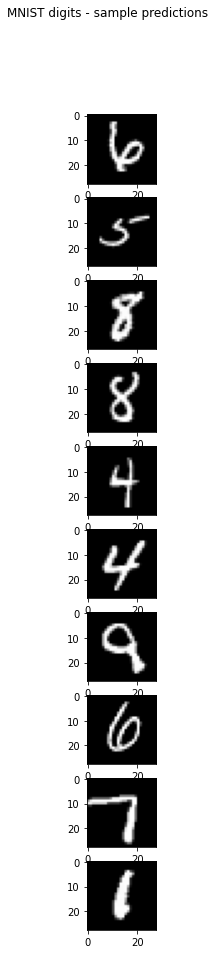

In [92]:
# Okay, let's plot an example digit, and the prediction the model makes

from matplotlib import pyplot as plt
import numpy as np

# Load the training dataset
transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=False, download=True,
                    transform=transform)
test_loader = torch.utils.data.DataLoader(dataset1, batch_size=10, shuffle=True)
"""
for test_images, test_labels in test_loader:  
    sample_image = test_images[0]    # Reshape them according to your needs.
    print(type(sample_image))
    print(sample_image.shape)
    sample_label = test_labels[0]
    break
"""

# Get 10 images
images, labels = next(iter(test_loader))
images_for_plot = images.reshape(images.shape[0], 28, 28)
#print(type(images))
#print(images.shape)
#first_sample = images[0]
#plt.imshow(first_sample, cmap='gray')
#plt.show()

device = torch.device("cuda")
with torch.no_grad():
    for i in range(10):
        this_image = images[i].to(device).reshape(-1)
        prediction = model(this_image)
        argmax = torch.argmax(prediction).item()
        print('prediction is ' + str(argmax))

fig, axs = plt.subplots(10, figsize=(15, 15))
fig.suptitle('MNIST digits - sample predictions')
for i in range(10):
    axs[i].imshow(images_for_plot[i], cmap='gray')
"""
fig = plt.figure()
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.tight_layout()
  plt.imshow(images[i], cmap='gray', interpolation='none')
  #plt.title("Prediction: {}".format(    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

device = torch.device("cuda")
#print(first_sample)
first_sample = first_sample.to(device)
# Okay, let's get a prediction
with torch.no_grad():
    prediction = model(first_sample.reshape(1, 28 * 28))
    print('prediction is ' + str(prediction))
    numeric_prediction = prediction.data.max(1, keepdim=True)[1][0].item()
    print(numeric_prediction)


# Next, let's look for one that is wrong
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        data = data.reshape(data.shape[0], -1)
        print(data.shape)
        predictions = model(data)
        for prediction in predictions:
            argmax = torch.argmax(prediction)
            print(argmax)
            break
        break
            #numeric_prediction = prediction.data.max(1, keepdim=True)[1][0].item()
            #print(numeric_prediction)
  """

We predicted 2 but the label was 7


<ipython-input-89-d5127a74feb5>:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


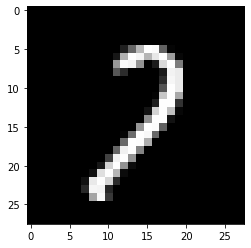

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


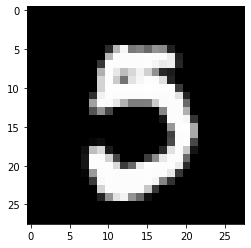

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 9 but the label was 7


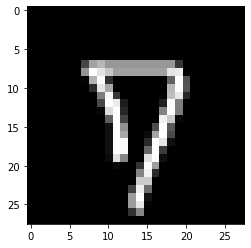

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 5 but the label was 6


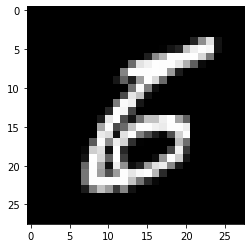

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 3


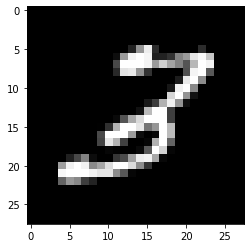

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 7 but the label was 2


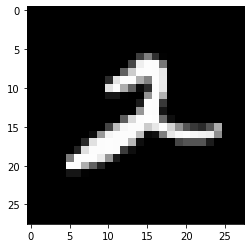

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


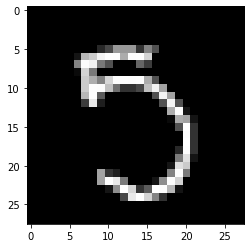

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 4


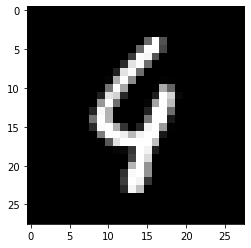

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 2 but the label was 4


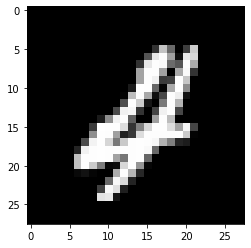

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


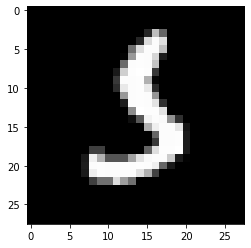

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


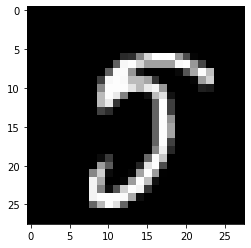

We predicted 3 but the label was 5


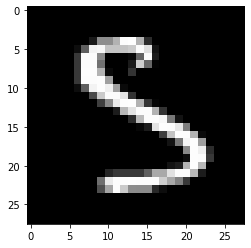

tensor([ True,  True, False,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 3 but the label was 2


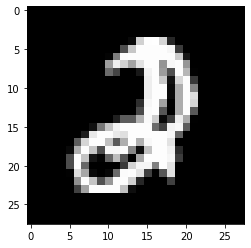

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 6


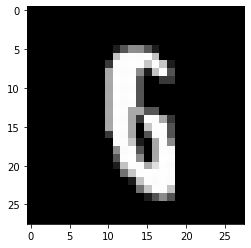

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 5 but the label was 6


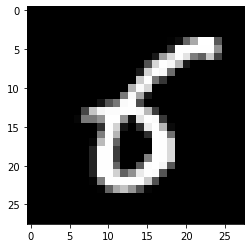

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 5 but the label was 6


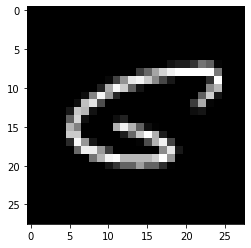

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 8 but the label was 2


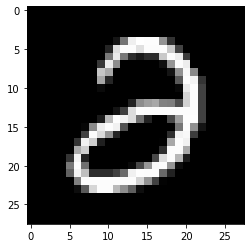

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 8


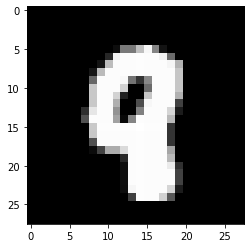

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


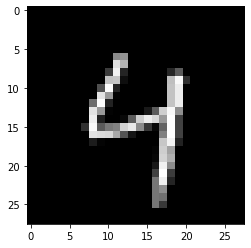

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


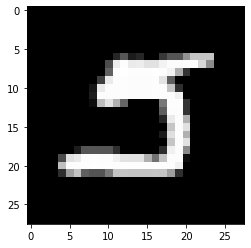

We predicted 5 but the label was 6


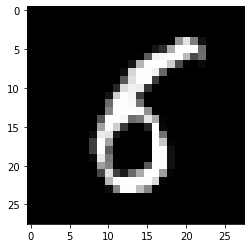

tensor([ True,  True,  True,  True, False,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


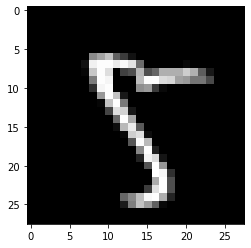

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


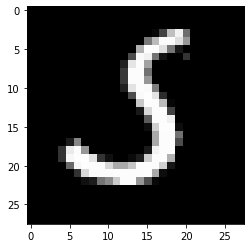

We predicted 8 but the label was 7


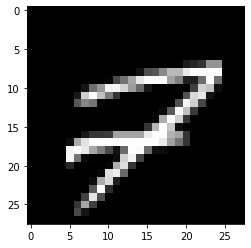

tensor([ True,  True,  True, False,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 5


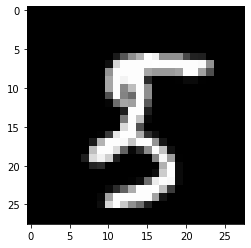

We predicted 8 but the label was 5


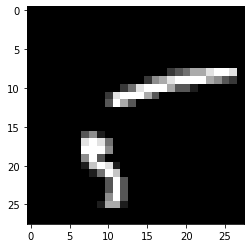

tensor([ True,  True,  True,  True, False,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 5 but the label was 6


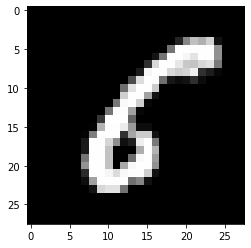

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 8


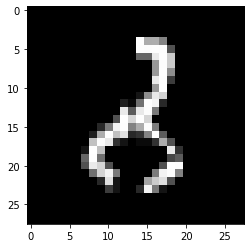

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


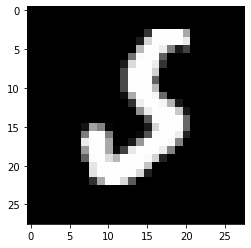

We predicted 7 but the label was 3


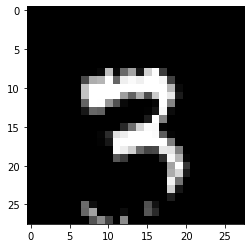

We predicted 7 but the label was 2


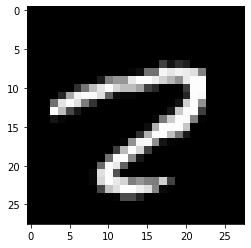

tensor([ True,  True,  True,  True, False,  True, False, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 6 but the label was 0


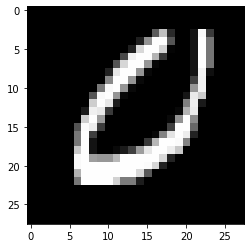

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 0 but the label was 4


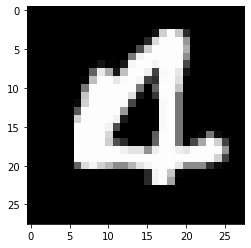

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


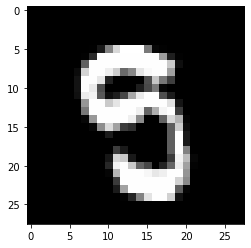

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 0


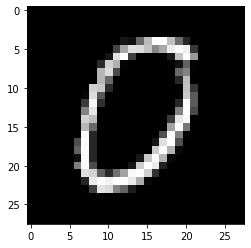

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


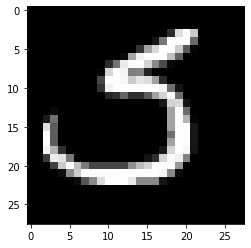

We predicted 4 but the label was 2


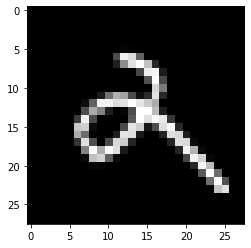

We predicted 7 but the label was 9


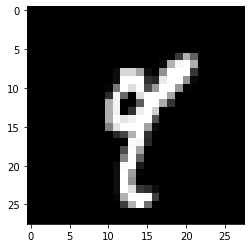

tensor([False,  True,  True,  True,  True,  True,  True, False,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 4


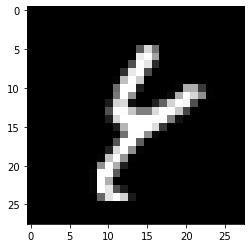

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 6 but the label was 8


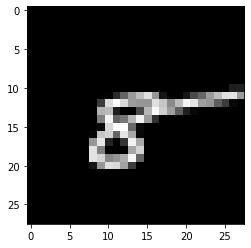

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 4


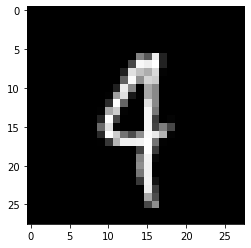

We predicted 7 but the label was 4


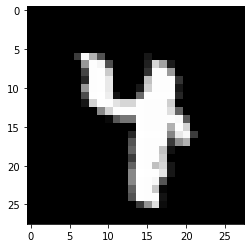

tensor([ True,  True, False,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 2 but the label was 7


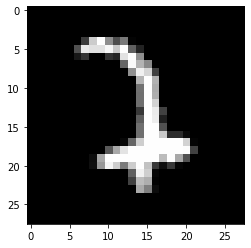

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 2


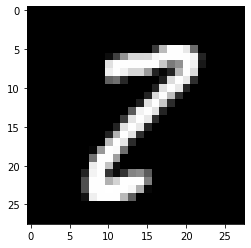

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


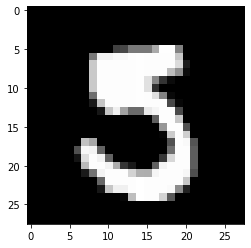

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 4


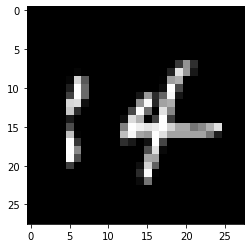

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


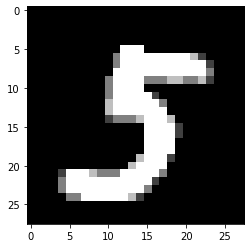

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 3


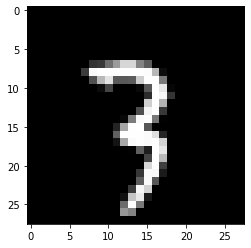

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 4 but the label was 2


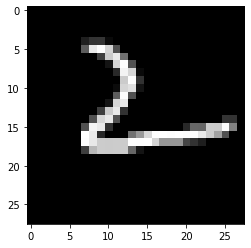

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 5


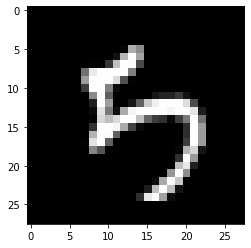

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 4 but the label was 2


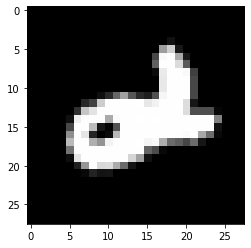

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 9


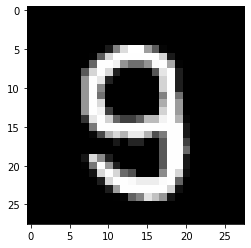

We predicted 8 but the label was 5


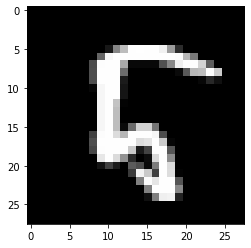

tensor([False, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 8


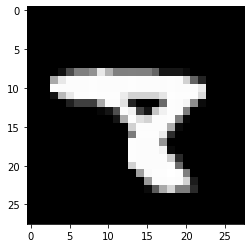

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 4 but the label was 2


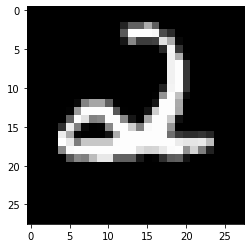

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


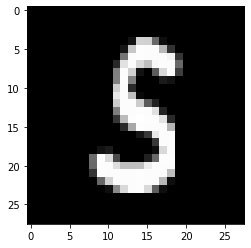

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


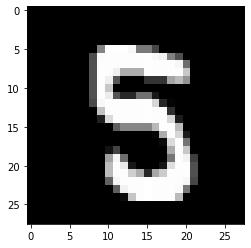

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


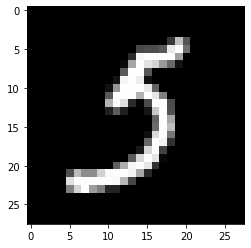

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 8 but the label was 5


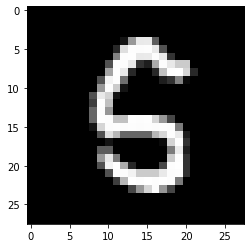

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 8


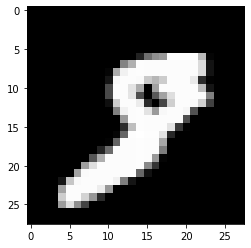

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


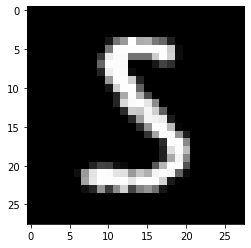

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


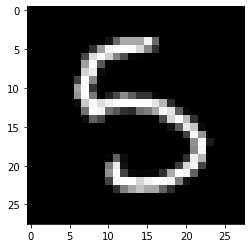

We predicted 7 but the label was 2


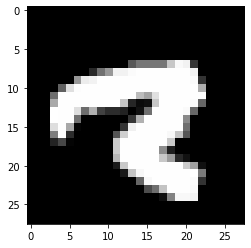

tensor([ True,  True,  True,  True, False, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 2


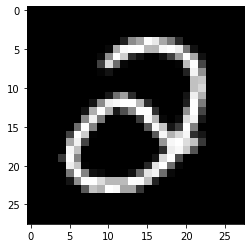

We predicted 8 but the label was 0


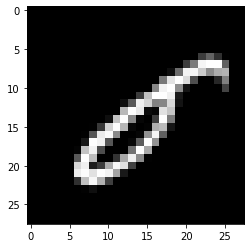

tensor([False,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 6 but the label was 2


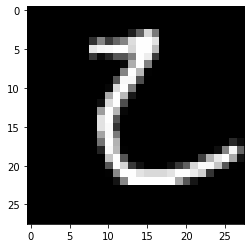

We predicted 2 but the label was 0


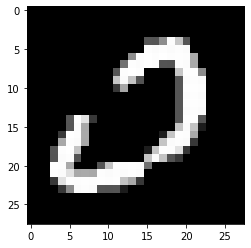

tensor([False,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 1 but the label was 6


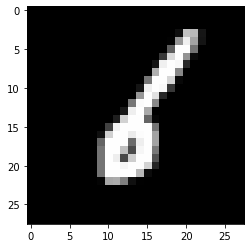

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 4 but the label was 0


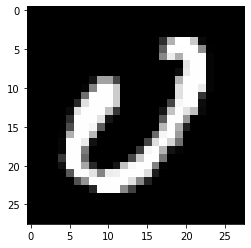

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 7 but the label was 9


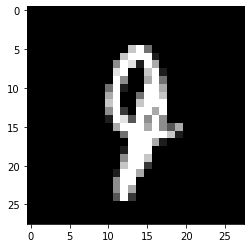

We predicted 3 but the label was 9


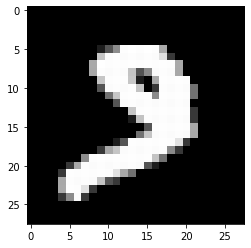

tensor([ True,  True, False,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 7 but the label was 9


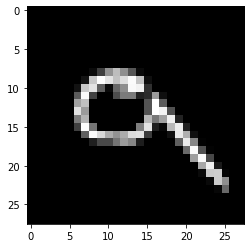

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 9


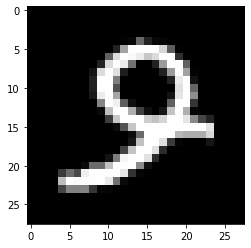

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 8


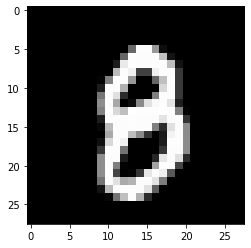

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 8


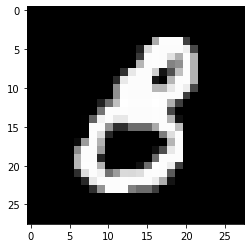

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 1 but the label was 7


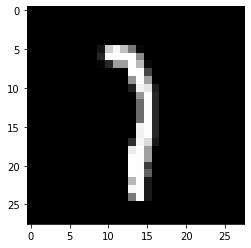

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


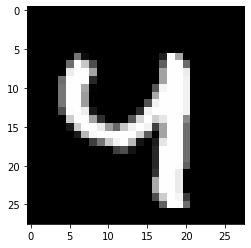

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 6


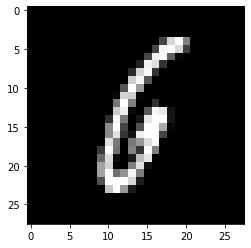

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 4


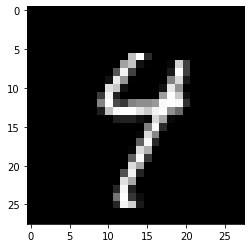

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 2 but the label was 7


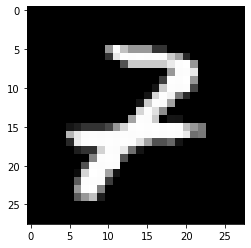

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 4


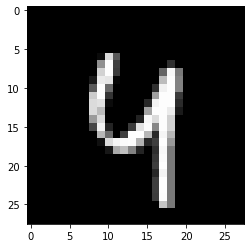

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 4


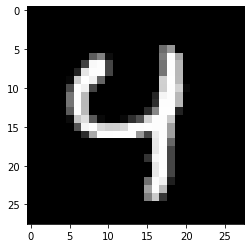

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 1


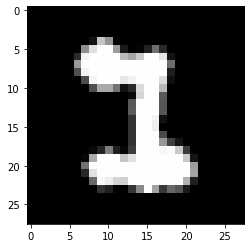

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 5


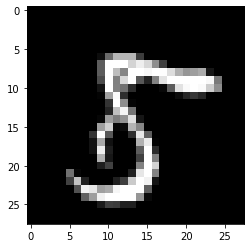

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 3


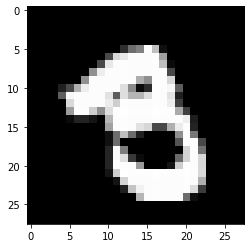

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 1 but the label was 9


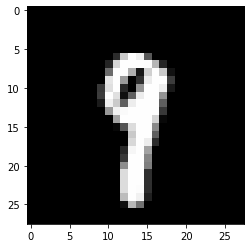

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 9 but the label was 4


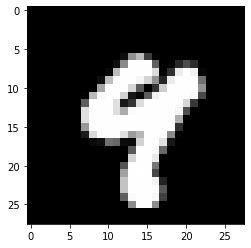

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


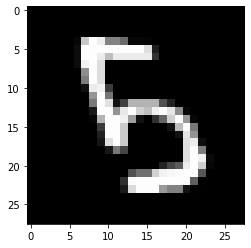

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


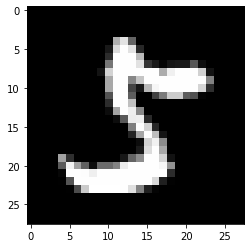

We predicted 8 but the label was 9


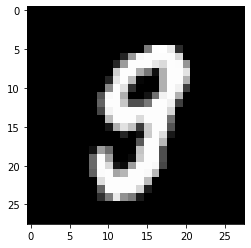

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


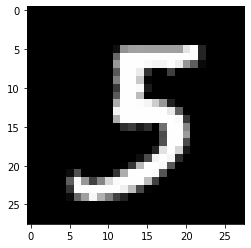

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


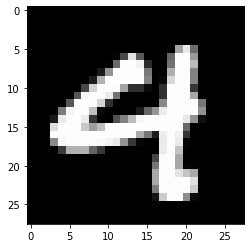

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 1


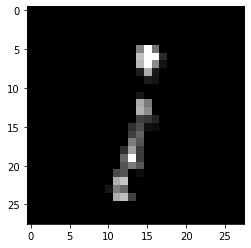

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 1 but the label was 8


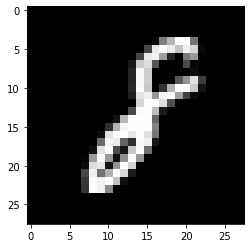

We predicted 7 but the label was 9


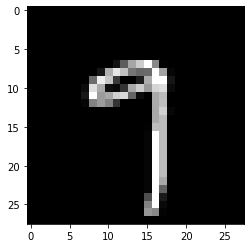

tensor([ True,  True, False,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


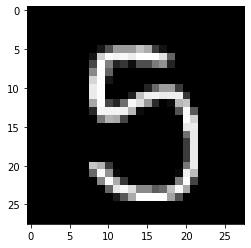

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 4 but the label was 5


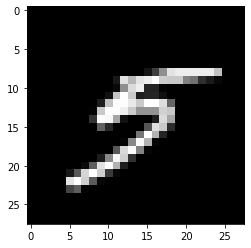

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


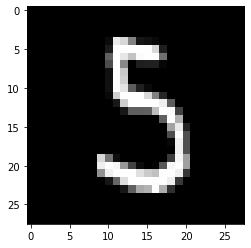

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 2


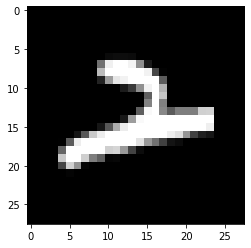

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 9 but the label was 5


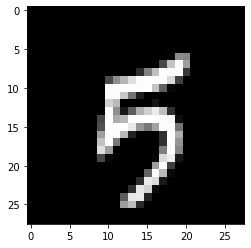

We predicted 9 but the label was 4


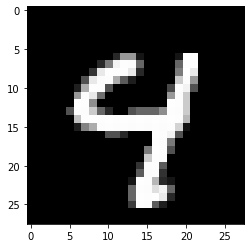

tensor([ True, False,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 6


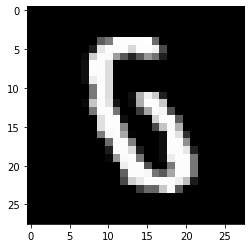

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 1 but the label was 9


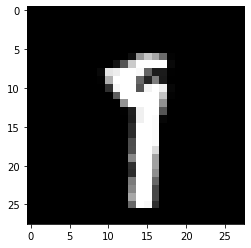

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 7 but the label was 2


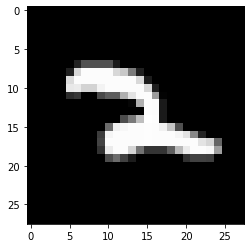

We predicted 7 but the label was 5


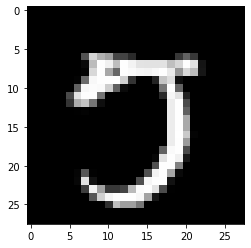

tensor([False,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


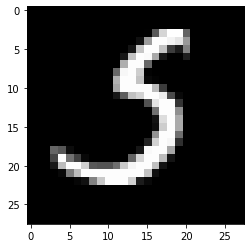

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 7 but the label was 2


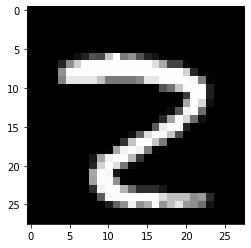

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 7 but the label was 6


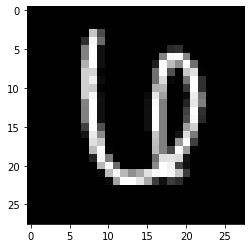

We predicted 6 but the label was 5


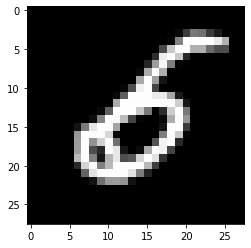

tensor([False, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 7


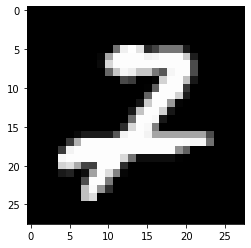

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 4 but the label was 9


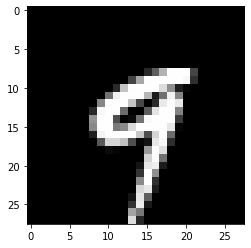

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 6 but the label was 4


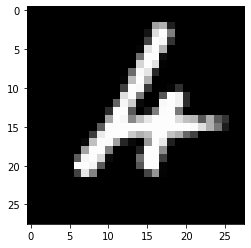

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 4 but the label was 5


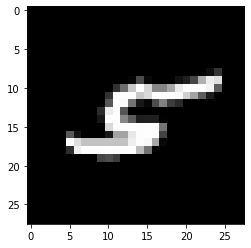

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 2 but the label was 8


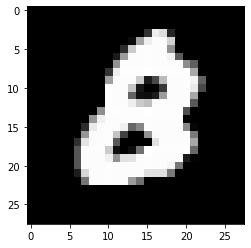

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


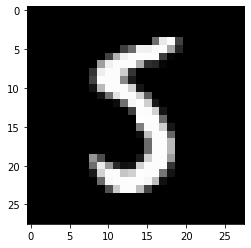

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 4 but the label was 9


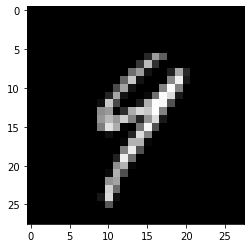

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 6 but the label was 4


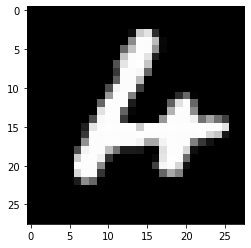

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


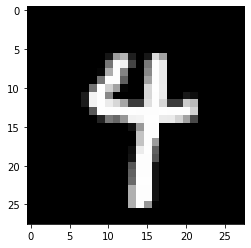

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


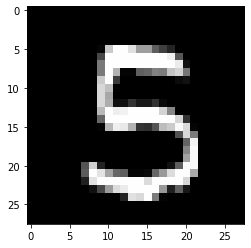

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 1 but the label was 9


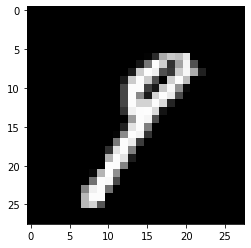

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 7


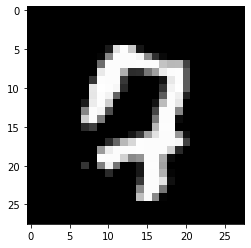

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


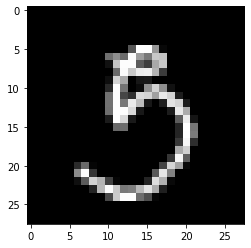

We predicted 6 but the label was 5


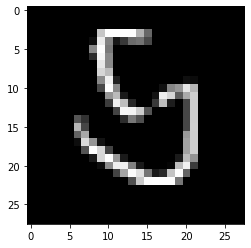

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 4 but the label was 6


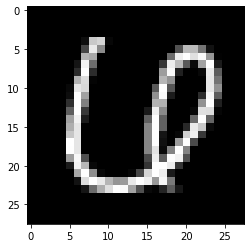

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 7 but the label was 9


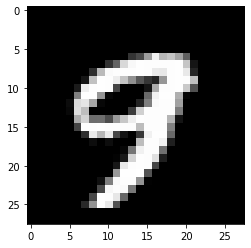

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


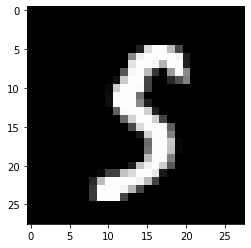

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 4


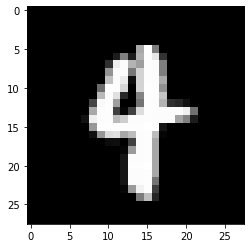

We predicted 3 but the label was 5


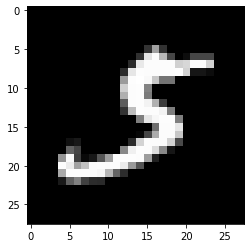

We predicted 9 but the label was 4


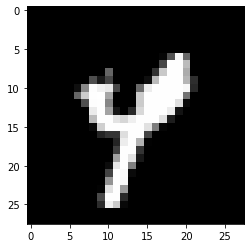

We predicted 8 but the label was 5


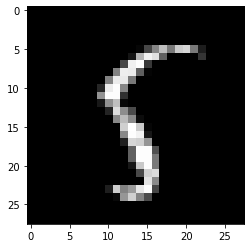

tensor([ True,  True, False, False, False,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 9


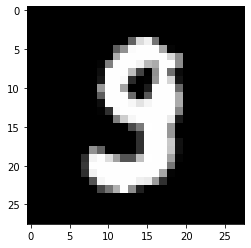

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 6 but the label was 5


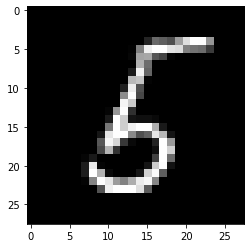

We predicted 8 but the label was 7


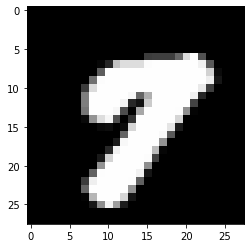

tensor([ True,  True,  True,  True,  True,  True, False, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 6 but the label was 2


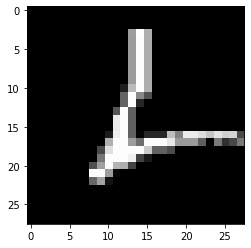

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 8


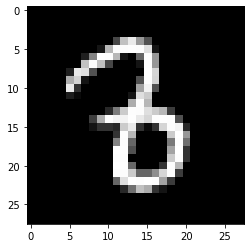

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 8


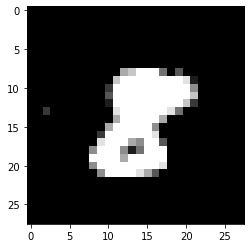

We predicted 2 but the label was 0


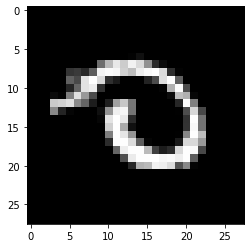

tensor([ True, False,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 2 but the label was 1


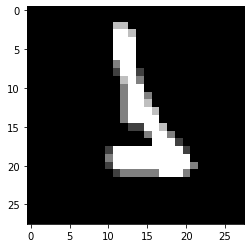

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 9


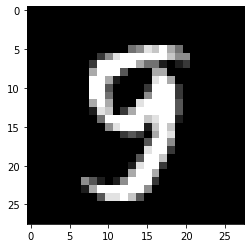

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 5


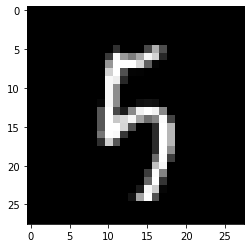

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 6


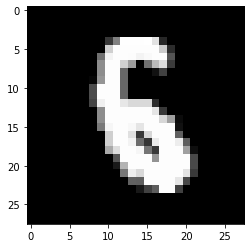

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 5


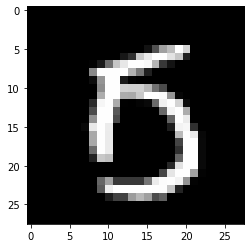

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


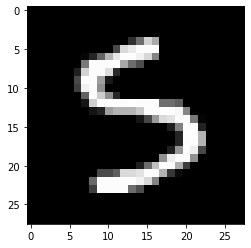

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 7


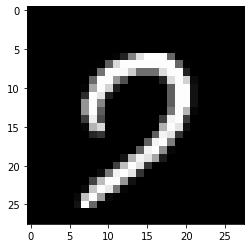

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


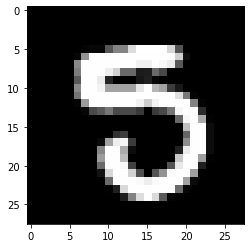

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


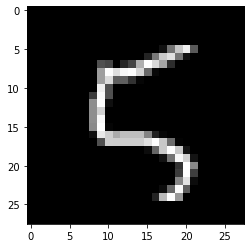

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 9 but the label was 5


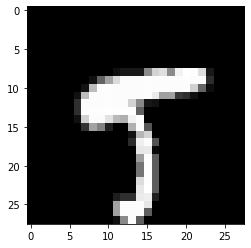

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


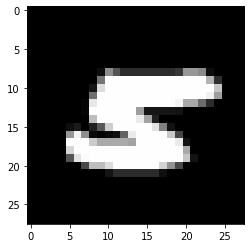

We predicted 3 but the label was 5


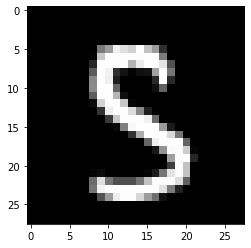

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 8


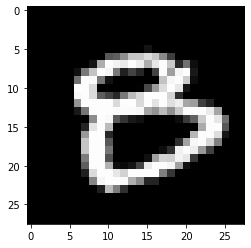

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


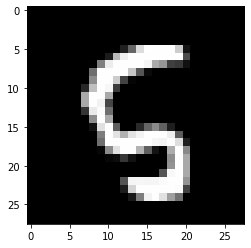

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 4


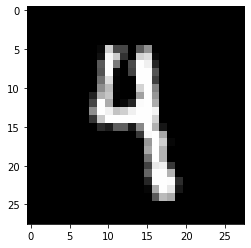

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


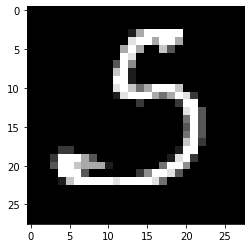

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 2 but the label was 3


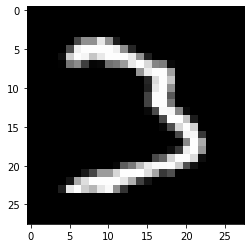

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 2 but the label was 0


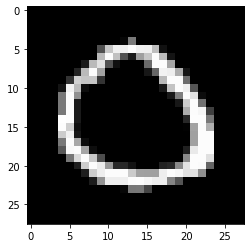

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 1 but the label was 4


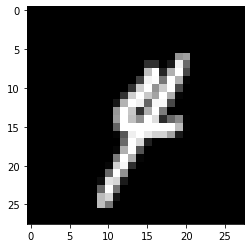

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 5


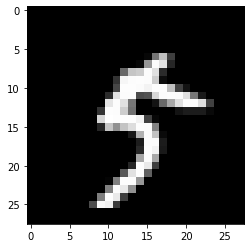

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 7 but the label was 9


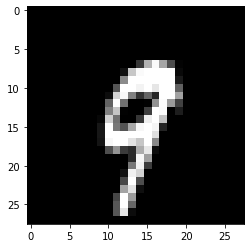

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 4 but the label was 5


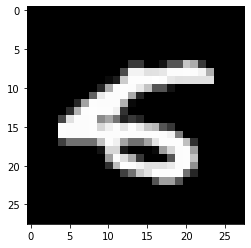

We predicted 3 but the label was 2


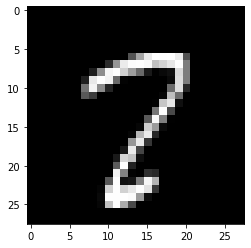

tensor([ True,  True,  True,  True, False,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 1


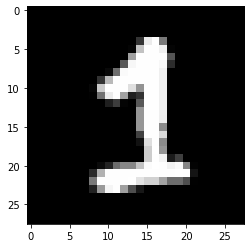

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 7 but the label was 9


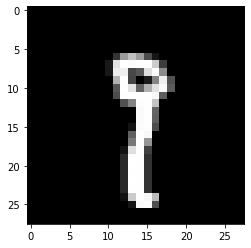

We predicted 7 but the label was 9


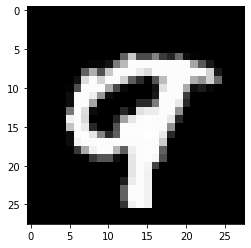

tensor([ True, False,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 4


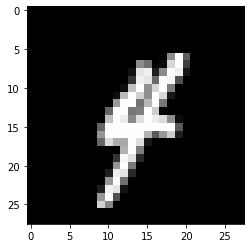

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


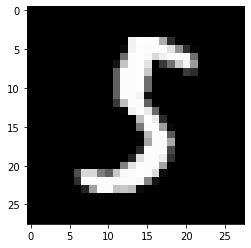

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 5


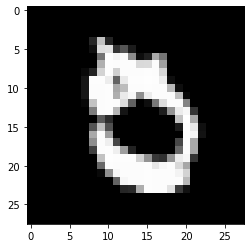

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


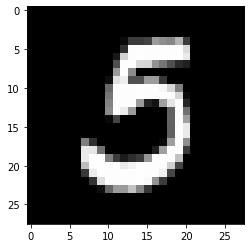

We predicted 0 but the label was 6


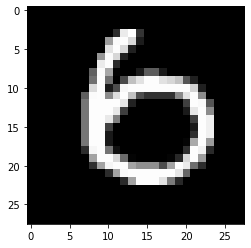

tensor([ True,  True,  True,  True,  True,  True, False, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 7 but the label was 9


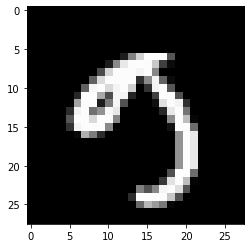

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 2 but the label was 8


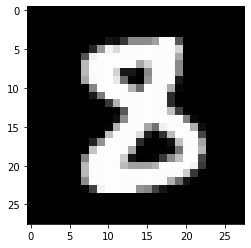

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


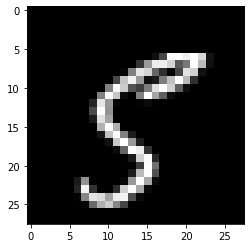

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


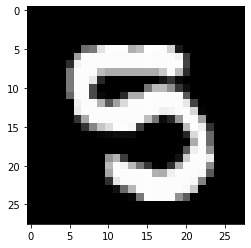

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 0


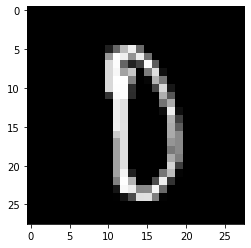

We predicted 8 but the label was 5


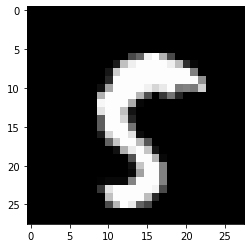

We predicted 8 but the label was 5


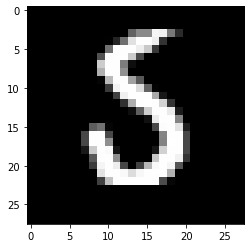

tensor([False, False,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


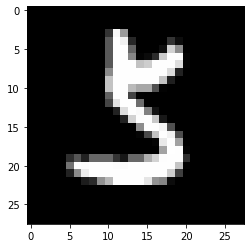

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 4 but the label was 2


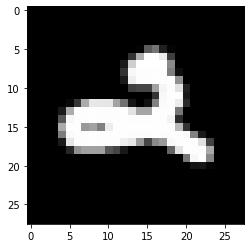

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 8 but the label was 5


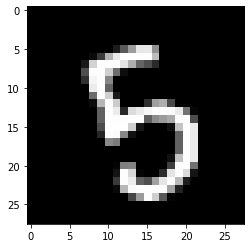

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 7 but the label was 2


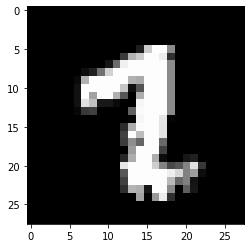

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 4 but the label was 6


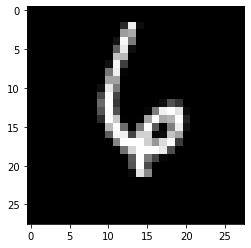

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 2 but the label was 3


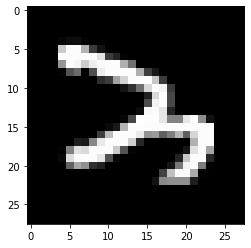

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 2


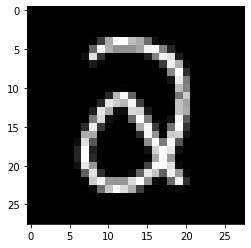

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 9


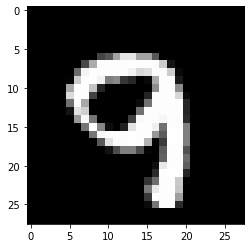

We predicted 9 but the label was 5


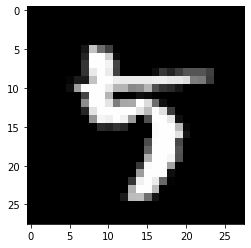

tensor([ True,  True, False,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 0


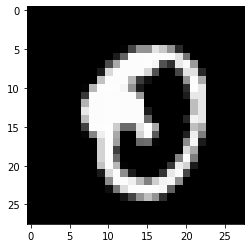

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 9


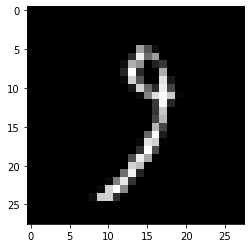

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 1 but the label was 6


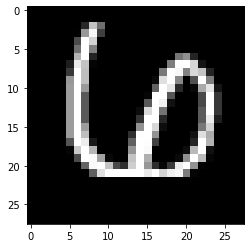

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 9 but the label was 3


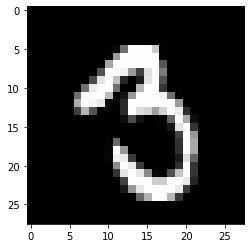

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


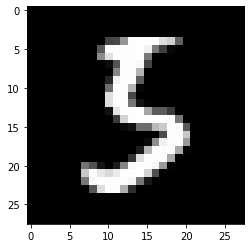

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 4


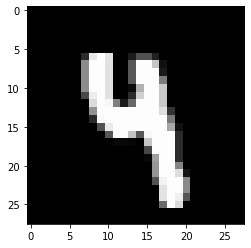

We predicted 9 but the label was 5


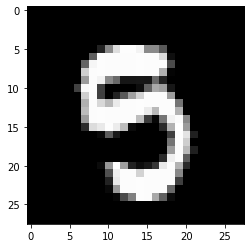

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 2


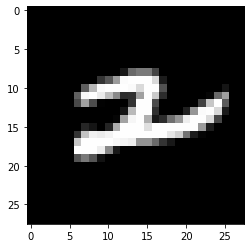

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


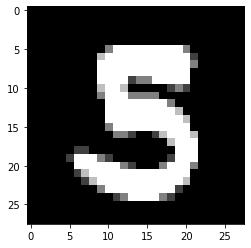

We predicted 3 but the label was 8


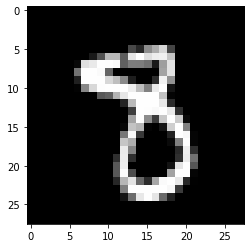

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 8 but the label was 5


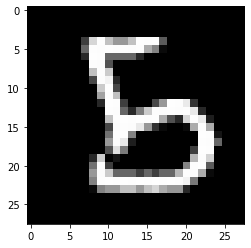

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 8 but the label was 4


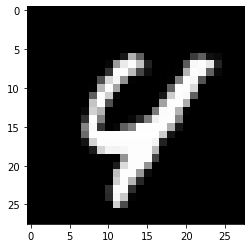

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 8


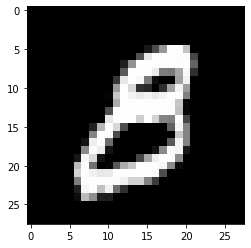

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


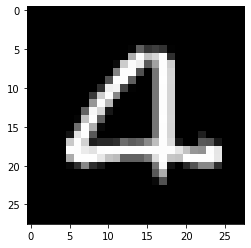

We predicted 3 but the label was 9


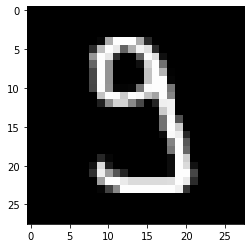

tensor([ True,  True,  True,  True,  True, False,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 8


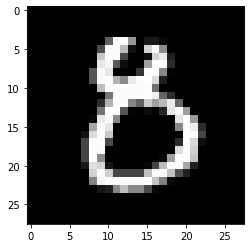

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 7 but the label was 8


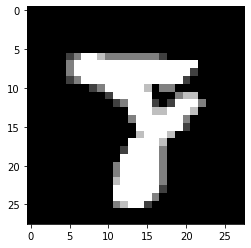

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 4


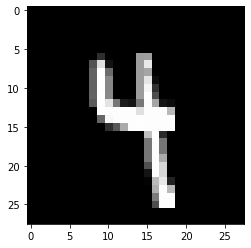

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 6 but the label was 2


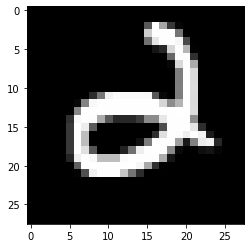

We predicted 6 but the label was 4


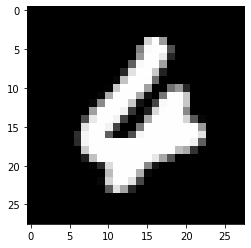

tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 4


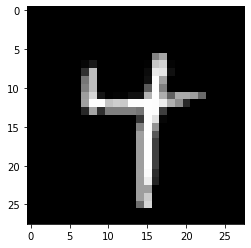

We predicted 1 but the label was 6


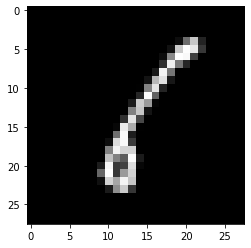

tensor([ True,  True,  True,  True, False,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 0


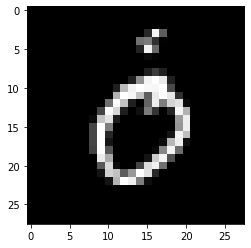

We predicted 3 but the label was 8


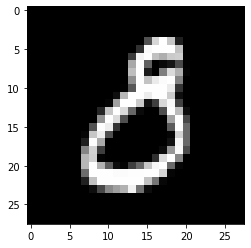

tensor([False, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


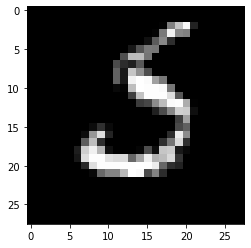

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 5


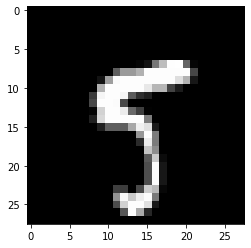

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 4


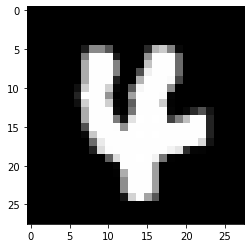

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 5


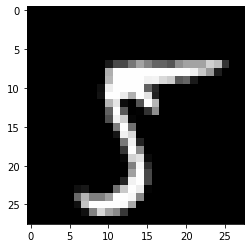

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 3


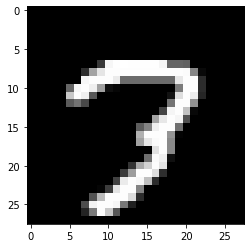

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


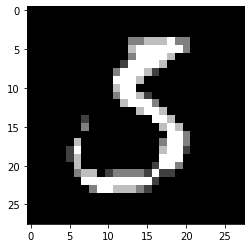

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 5


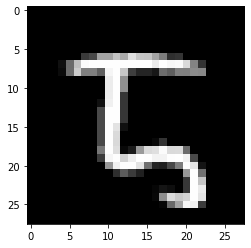

We predicted 9 but the label was 4


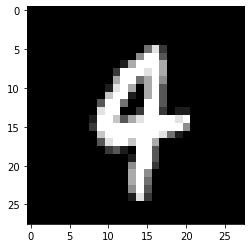

tensor([ True,  True,  True,  True, False, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


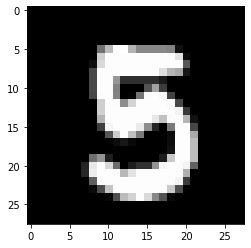

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 9


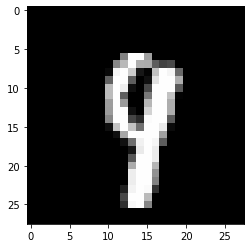

We predicted 6 but the label was 2


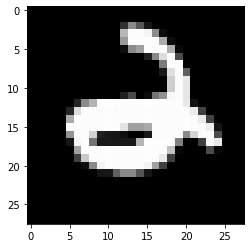

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 6


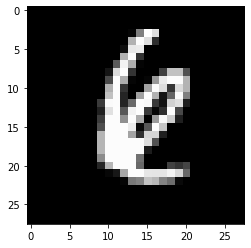

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


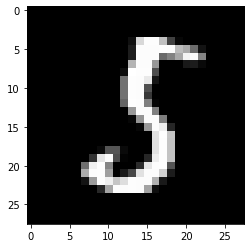

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


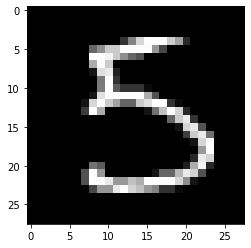

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 2 but the label was 7


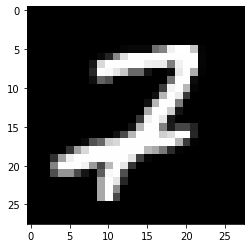

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 8


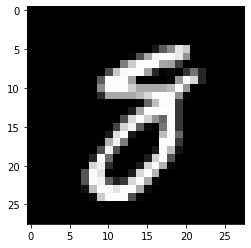

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


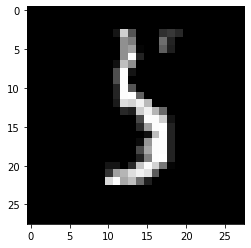

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


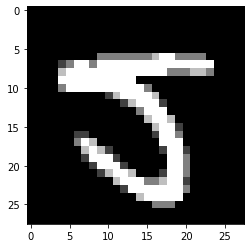

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


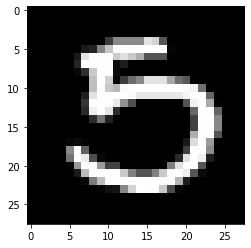

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 4 but the label was 2


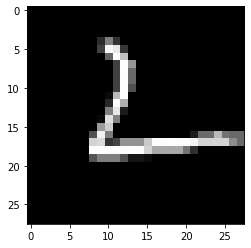

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 5


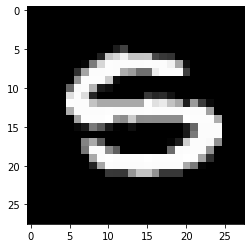

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 1 but the label was 9


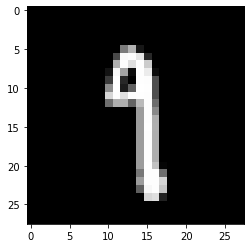

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 2


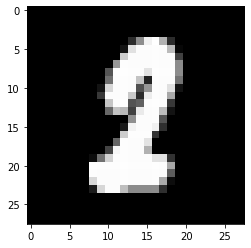

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 5


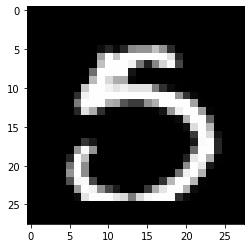

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


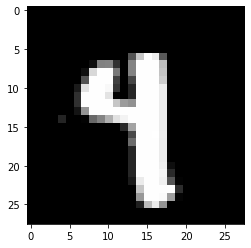

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


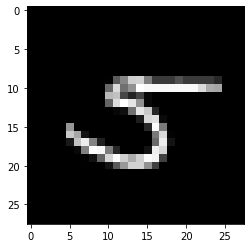

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 0


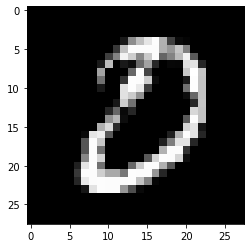

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 4 but the label was 9


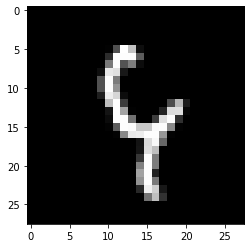

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


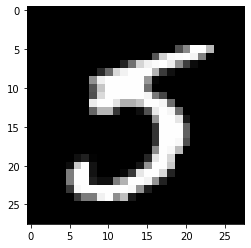

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 5


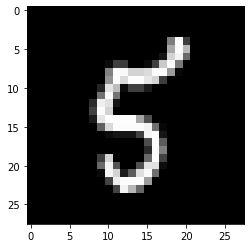

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


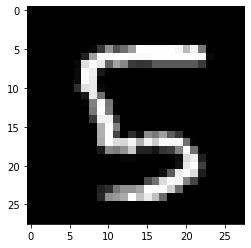

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 8 but the label was 9


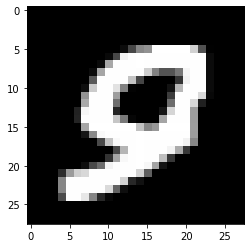

We predicted 8 but the label was 9


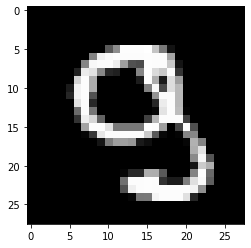

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 3 but the label was 8


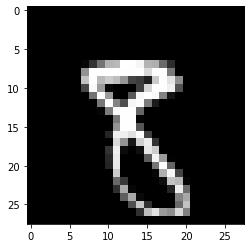

We predicted 8 but the label was 9


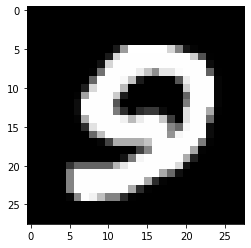

tensor([ True, False,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 1 but the label was 6


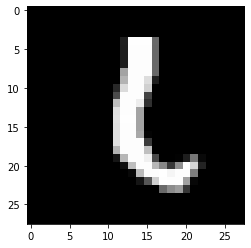

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 3


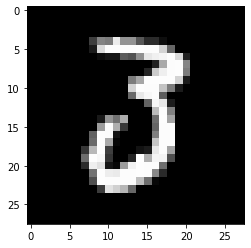

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 5


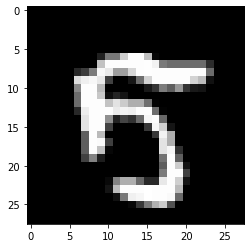

We predicted 9 but the label was 4


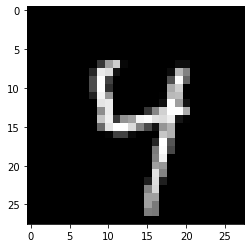

We predicted 6 but the label was 5


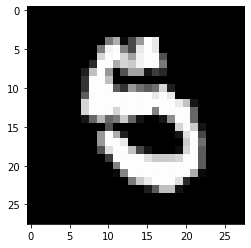

tensor([ True,  True,  True,  True,  True, False, False,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 1


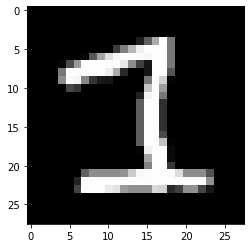

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 7 but the label was 4


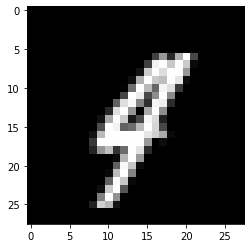

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 0


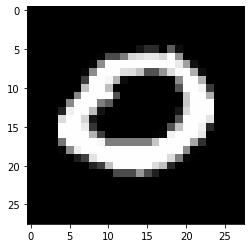

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


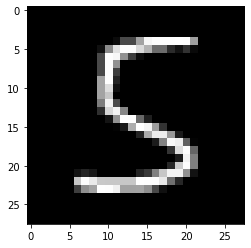

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 4


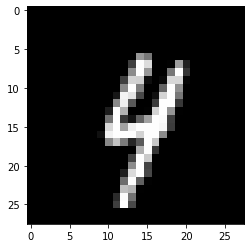

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 9 but the label was 5


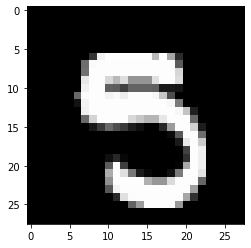

We predicted 8 but the label was 2


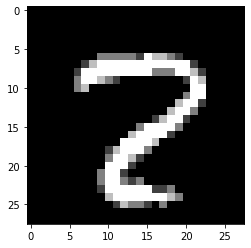

tensor([ True,  True,  True,  True,  True,  True, False,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 7 but the label was 2


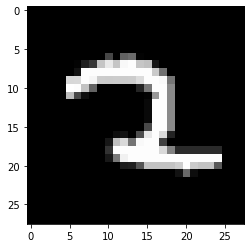

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 1 but the label was 4


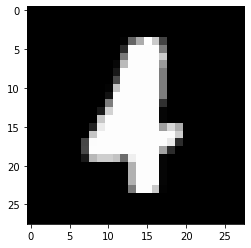

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 7 but the label was 4


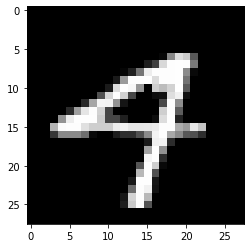

We predicted 3 but the label was 5


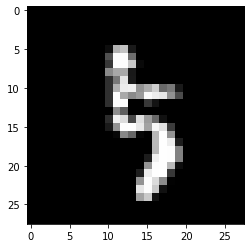

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 6 but the label was 5


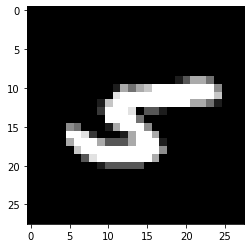

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 6


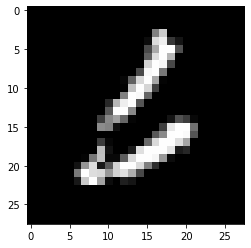

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 6 but the label was 9


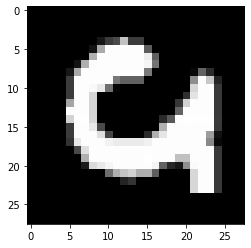

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


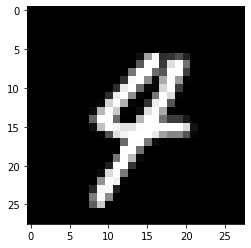

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 6 but the label was 5


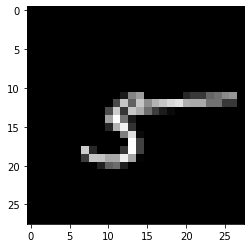

We predicted 7 but the label was 4


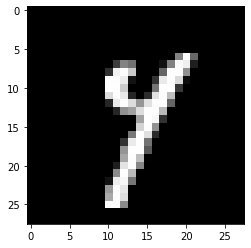

tensor([ True,  True, False,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 8 but the label was 5


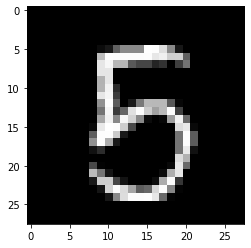

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 6 but the label was 1


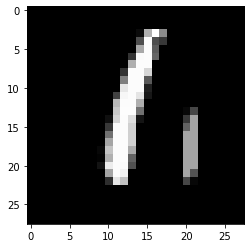

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 6


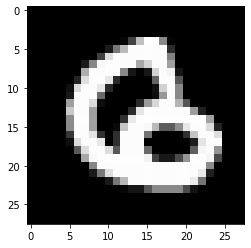

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 6


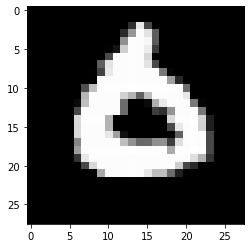

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 8 but the label was 9


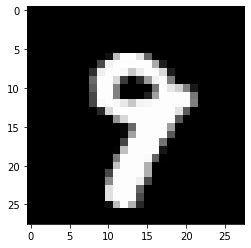

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 4


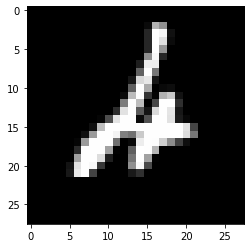

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 3


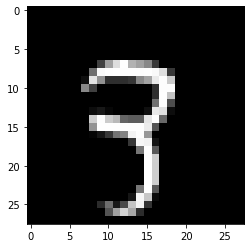

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 3


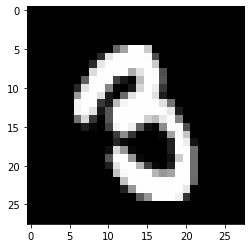

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 2


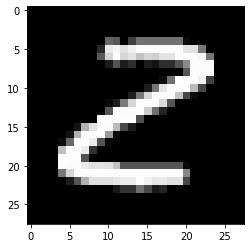

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 9 but the label was 4


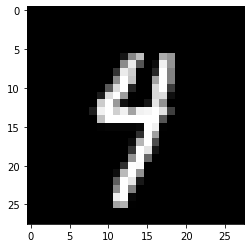

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 9


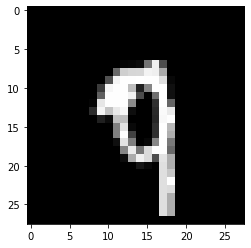

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 4


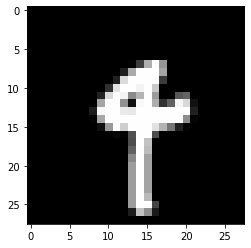

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 8 but the label was 5


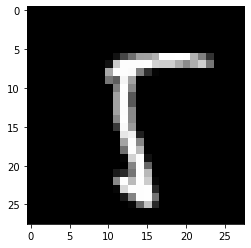

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 1 but the label was 4


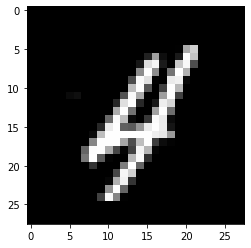

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


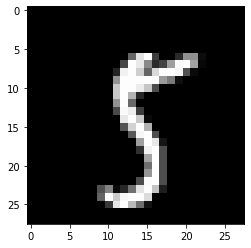

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 8 but the label was 5


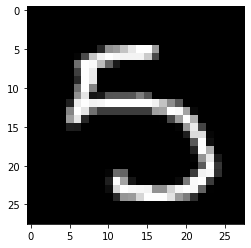

We predicted 3 but the label was 9


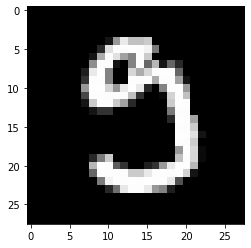

tensor([ True,  True,  True,  True,  True, False,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 7 but the label was 8


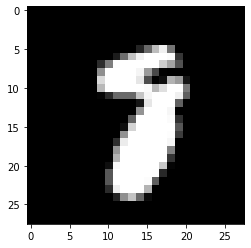

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 9


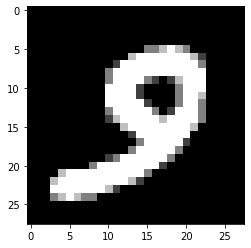

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 1 but the label was 9


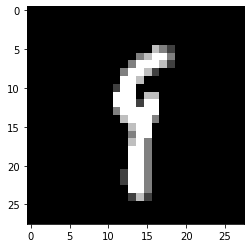

We predicted 1 but the label was 5


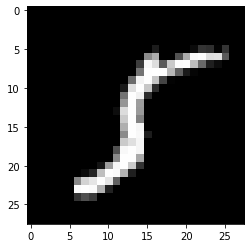

tensor([ True,  True, False,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 2 but the label was 6


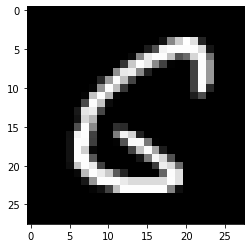

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 4


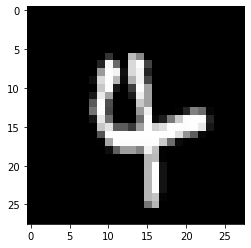

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 1 but the label was 0


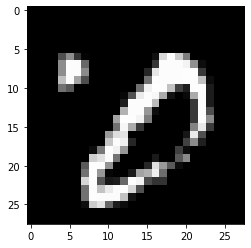

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 8 but the label was 5


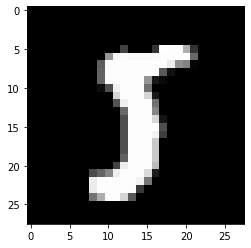

We predicted 9 but the label was 4


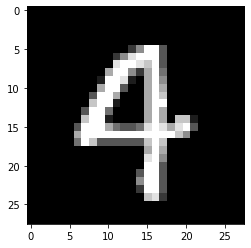

tensor([ True, False,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 8 but the label was 4


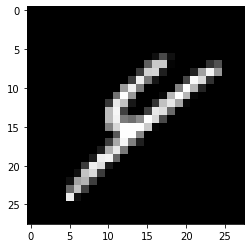

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


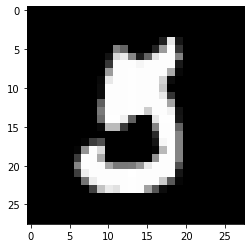

We predicted 3 but the label was 5


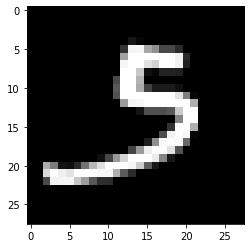

tensor([ True,  True, False,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 2 but the label was 1


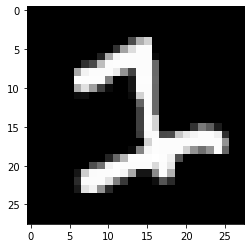

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 9


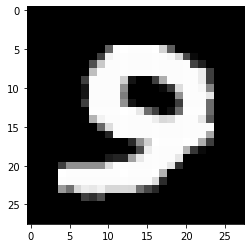

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 7 but the label was 4


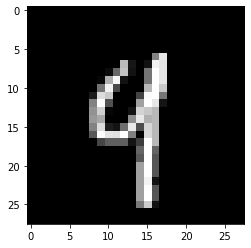

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 7 but the label was 9


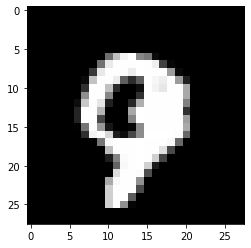

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


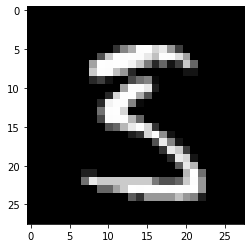

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 9


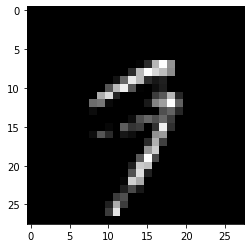

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 6 but the label was 2


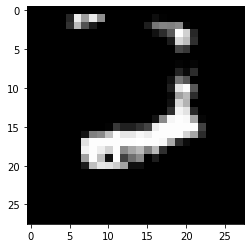

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 2 but the label was 8


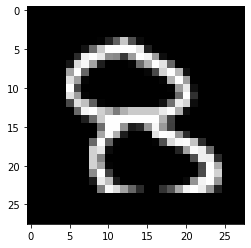

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 8 but the label was 5


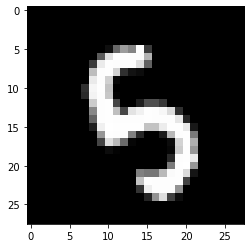

We predicted 8 but the label was 5


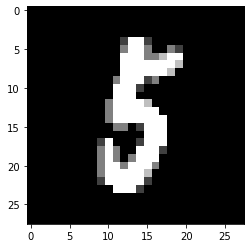

tensor([False,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 5


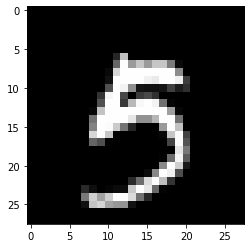

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 8 but the label was 5


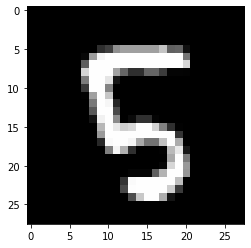

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 7 but the label was 2


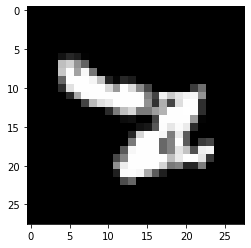

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 7 but the label was 2


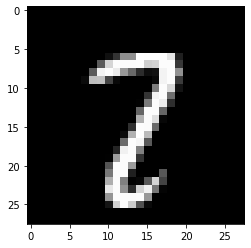

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 4


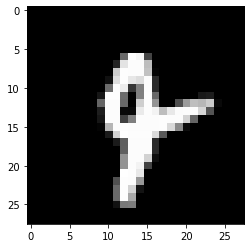

We predicted 7 but the label was 9


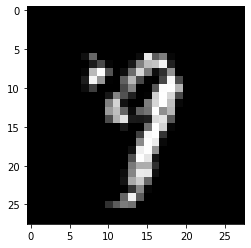

tensor([ True,  True,  True,  True,  True,  True,  True, False, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 2


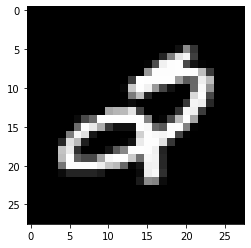

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 4


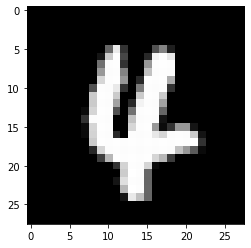

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


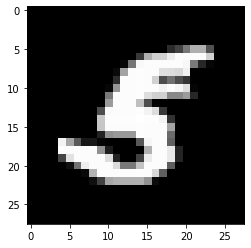

We predicted 1 but the label was 7


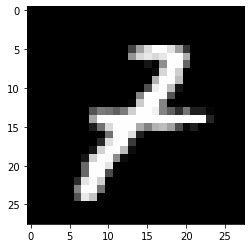

tensor([ True,  True,  True, False, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 8 but the label was 1


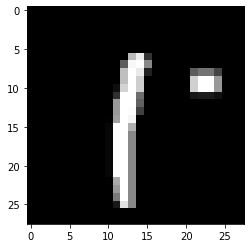

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 8 but the label was 2


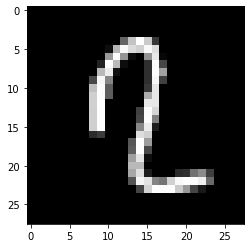

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 7 but the label was 9


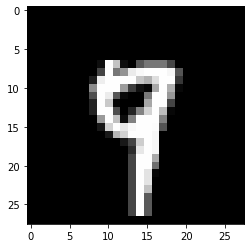

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 8 but the label was 5


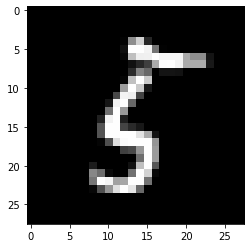

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 8 but the label was 0


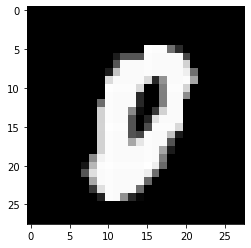

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 5


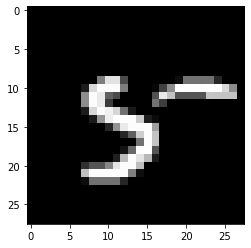

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 6 but the label was 4


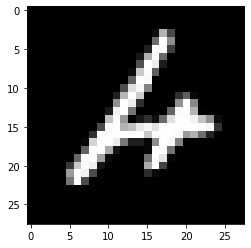

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


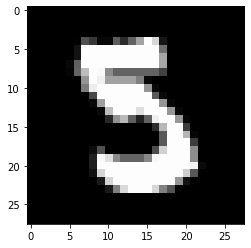

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 4 but the label was 9


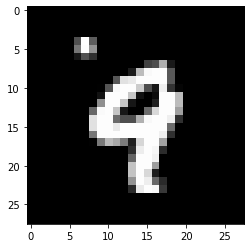

We predicted 3 but the label was 5


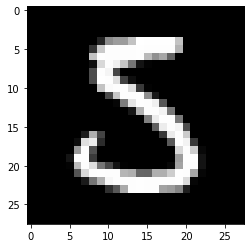

tensor([ True,  True,  True,  True, False,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


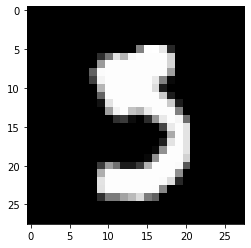

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 3


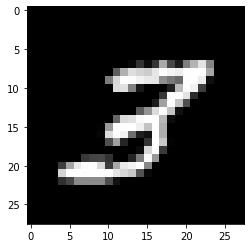

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


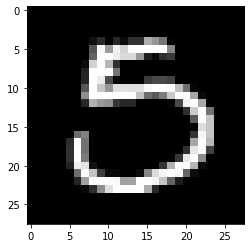

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


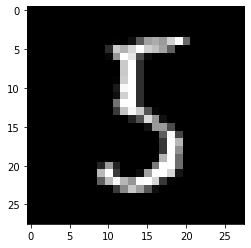

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 8 but the label was 6


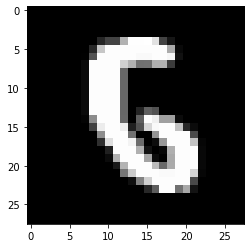

We predicted 0 but the label was 8


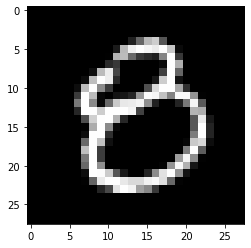

tensor([ True,  True, False,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


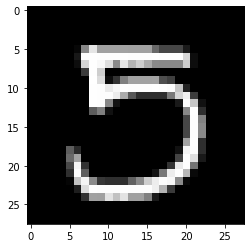

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 8


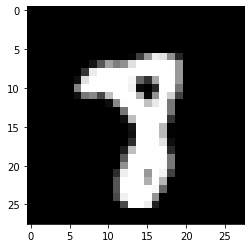

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 8


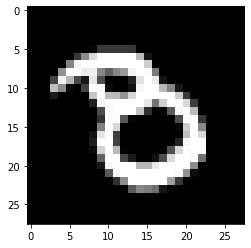

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


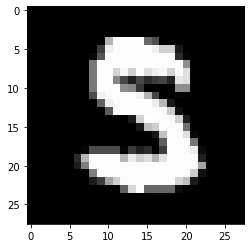

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 7 but the label was 2


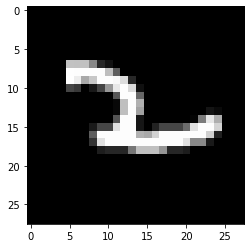

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


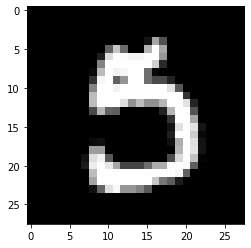

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 9 but the label was 4


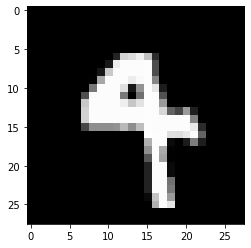

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 2 but the label was 3


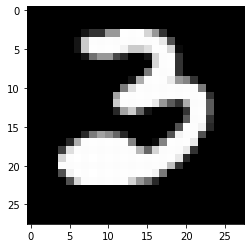

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


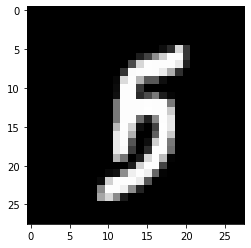

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


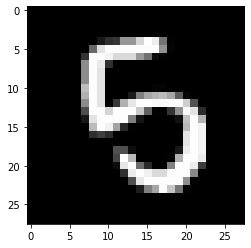

tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 3


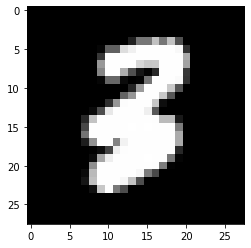

We predicted 3 but the label was 5


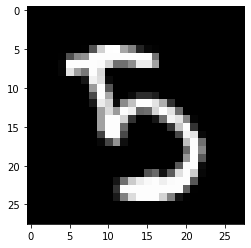

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 8 but the label was 5


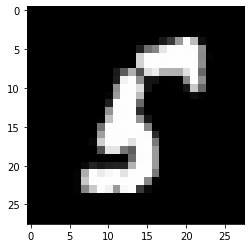

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 8 but the label was 5


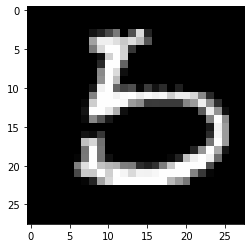

We predicted 6 but the label was 5


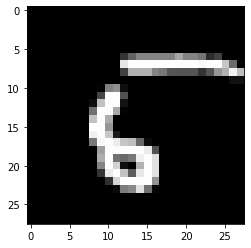

tensor([ True,  True, False,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


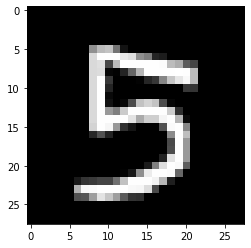

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 6


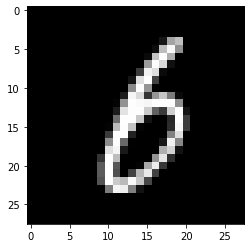

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 1 but the label was 7


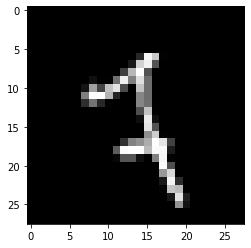

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 6 but the label was 7


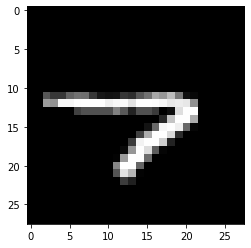

We predicted 8 but the label was 5


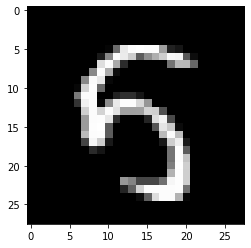

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


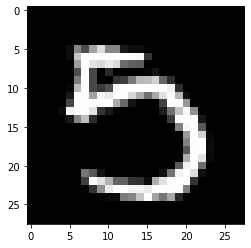

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


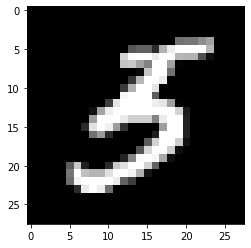

tensor([ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 9 but the label was 5


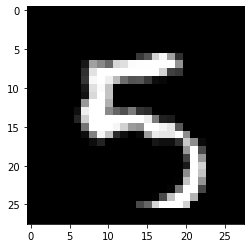

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 1 but the label was 9


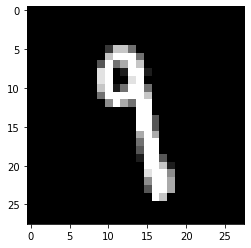

We predicted 8 but the label was 7


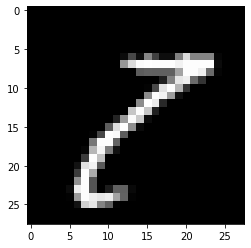

We predicted 8 but the label was 5


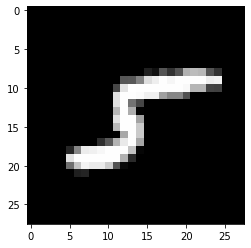

tensor([ True,  True,  True,  True, False, False, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 9


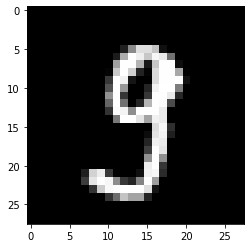

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 2 but the label was 7


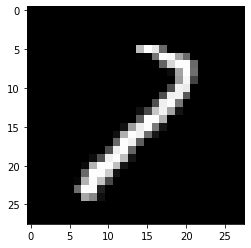

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 5


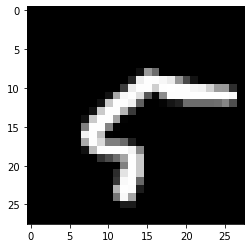

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


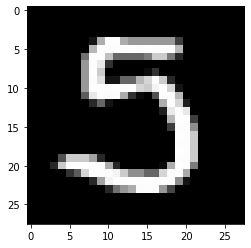

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 6 but the label was 5


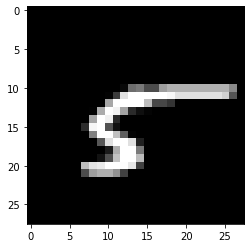

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 4


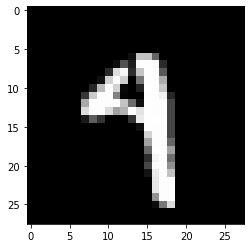

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 8


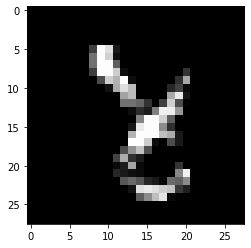

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 9 but the label was 4


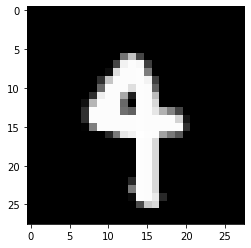

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 9


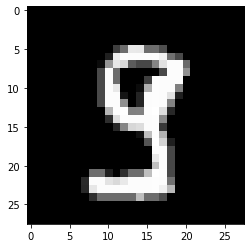

We predicted 6 but the label was 5


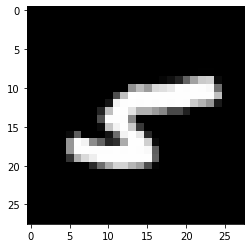

tensor([ True,  True,  True,  True,  True, False,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 8


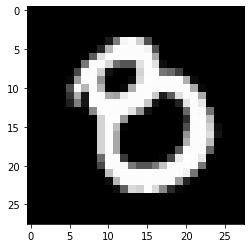

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 3


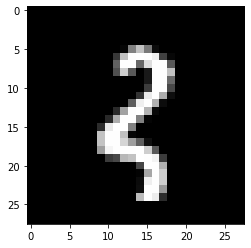

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 0 but the label was 5


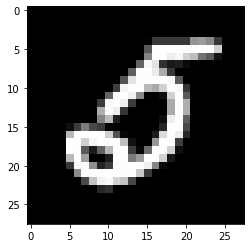

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 1 but the label was 9


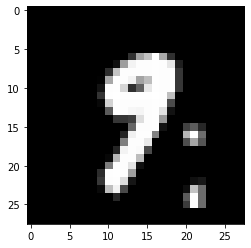

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 3 but the label was 5


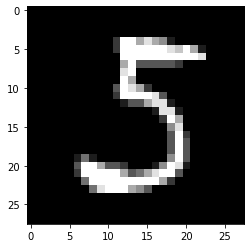

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


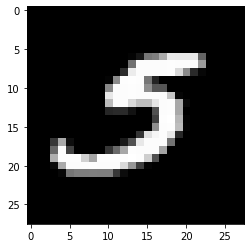

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


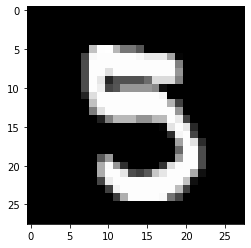

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 1 but the label was 9


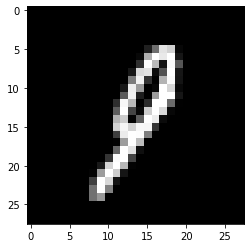

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 4


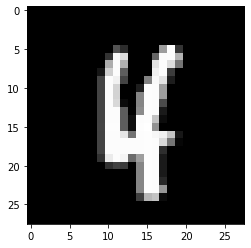

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 9 but the label was 4


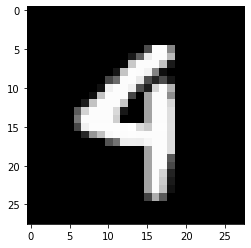

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 2


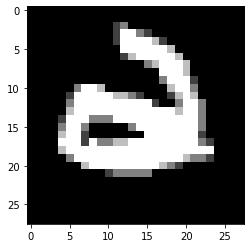

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
We predicted 8 but the label was 5


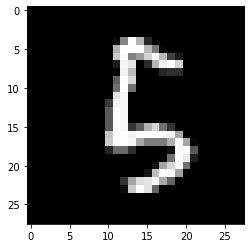

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 6 but the label was 5


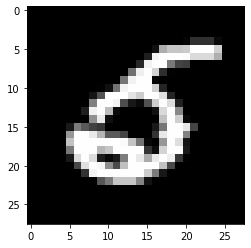

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 8 but the label was 6


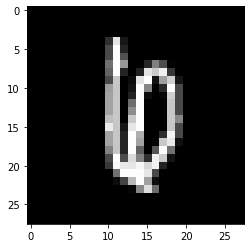

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


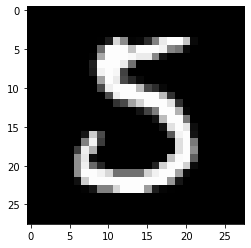

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 3 but the label was 5


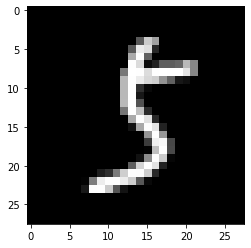

We predicted 3 but the label was 5


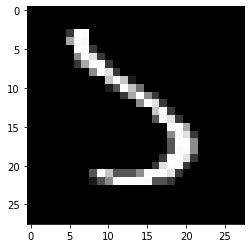

tensor([False,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 6


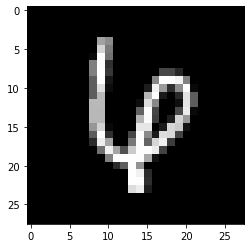

We predicted 3 but the label was 9


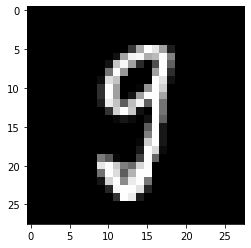

tensor([ True,  True, False,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


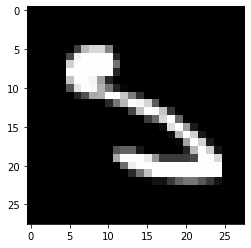

We predicted 0 but the label was 6


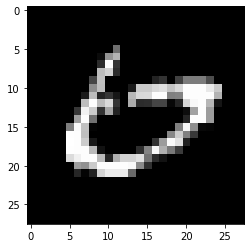

tensor([ True,  True,  True,  True, False,  True,  True, False,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
We predicted 9 but the label was 4


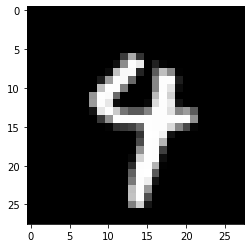

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


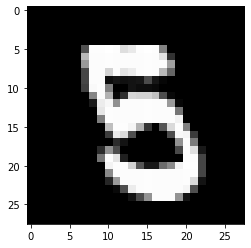

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 1 but the label was 9


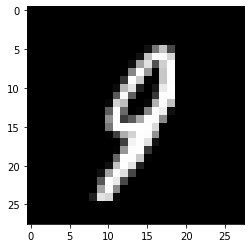

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 3 but the label was 8


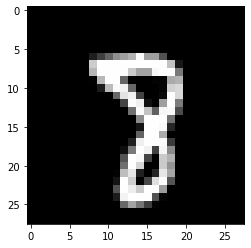

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 3 but the label was 5


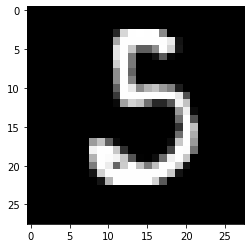

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 5 but the label was 6


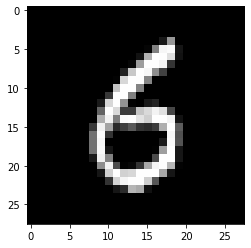

tensor([ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 4 but the label was 6


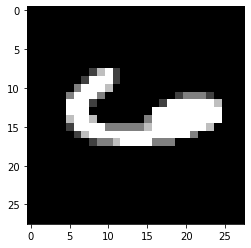

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
All clean
We predicted 7 but the label was 0


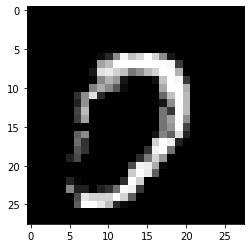

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 3 but the label was 5


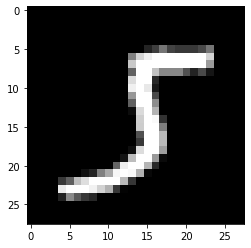

tensor([ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
All clean
All clean
We predicted 7 but the label was 3


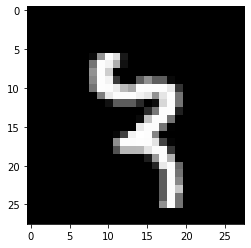

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 4


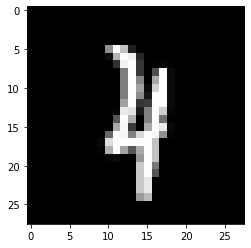

tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 7 but the label was 9


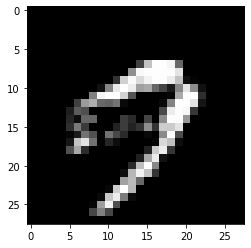

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 4 but the label was 6


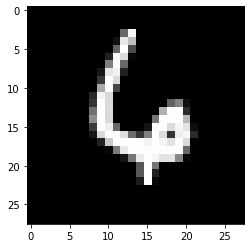

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
All clean
We predicted 0 but the label was 6


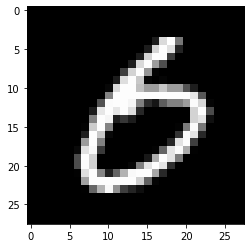

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
       device='cuda:0')
torch.Size([10])
We predicted 0 but the label was 5


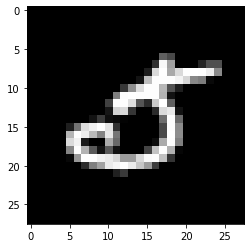

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
We predicted 1 but the label was 9


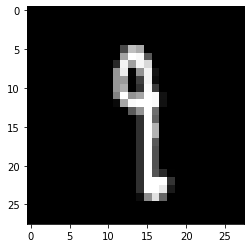

tensor([ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
       device='cuda:0')
torch.Size([10])
All clean
All clean
We predicted 9 but the label was 4


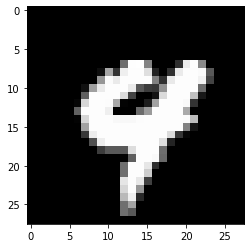

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')
torch.Size([10])


In [94]:
# Next, let's look for any digits that we do not get right

# Load the training dataset
transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=False, download=True,
                    transform=transform)
test_loader = torch.utils.data.DataLoader(dataset1, batch_size=10, shuffle=True)

# Get 10 images
#images, labels = next(iter(test_loader))
#images_for_plot = images.reshape(images.shape[0], 28, 28)
#print(type(images))
#print(images.shape)
#first_sample = images[0]
#plt.imshow(first_sample, cmap='gray')
#plt.show()

device = torch.device("cuda")
with torch.no_grad():
    # For each batch
    for data, target in test_loader:
        # Move to CUDA
        data, target = data.to(device), target.to(device)
        # Now, we need make sure our image data is 'flat' - a 784 column vector per instance, not 1 x 28 x 28
        data = torch.reshape(data, (data.shape[0], -1))
        # Compute the forward pass
        output = model(data)
        # Find the predictions. This will be the element in the test instance with the strongest 'signal' - our softmax output - which is a probablility prediction.
        pred = output.argmax(dim=1, keepdim=True)  
        # Calculate the number of predictions we got right; by summing the matches between our predictions and the targets
        results = pred.eq(target.view_as(pred)).reshape(-1)
        if torch.any(results == False):
            # We found a false!
            # First, print out prediction for the False on
            for ix in range(len(pred)):
                if pred[ix] != target.view_as(pred)[ix]:
                    print("We predicted " + str(pred[ix].item()) + ' but the label was ' + str(target.view_as(pred)[ix].item()))
                    #print(data.shape)
                    plt.imshow(data[ix].reshape(28, 28).cpu(), cmap='gray')
                    plt.show()
            #print(type(images))
#print(images.shape)
#first_sample = images[0]
#plt.imshow(first_sample, cmap='gray')
#plt.show()
            print(results)
            print(results.shape)

            #break
        else:
            print('All clean')